# Chapter 7. Ensemble Learning and Random Forests
___

**wisdom of the crowd** 

: 무작위로 선택된 수천 명의 사람에게 복잡한 질문을 하고 대답을 모으면 많은 경우 전문가의 답보다 이렇게 모은 답이 낫다.

이와 유사하게 predictor들로 부터 예측값들을 수집하면 가장 뛰어난 하나의 predictor보다 좋은 성능을 보일때가 있다

이것을 **Ensemble** 이라 하고 이 기법을 **Ensemble Learning**, 이 Ensemble Learning algorithm 을 **Ensemble method**이라 한다.

## 7.1 Voting Classifier
___

![img_1](./imgs/7-1-1.png)

예시 : 

정확도가 80% 정도인 여러 classifier 들(Logistic Regression / SVM Classifier / Random Forest Classifier...)을 훈련시킨 것들이 있다고 가정했을 때(fig 1), 

더 좋은 classifier를 만드는 방법은 classifier들의 각 예측 값들을 모아서, 가장 많은 득표를 얻은 class로 예측하는 방법이다.

이와 같은 **majority-vote** classifier를 **hard voting classifier** 라고 한다.(fig 2)

![img_2](./imgs/7-1-2.png)

이와 같은 classifier는 ensemble에 속한 가장 좋은 classifier 보다 높은 정확도를 갖는다.

Ensemble에 weak learner (classifier) 들이 속해 있다고 하더라도 classifier들이 **충분히 많고 다양하다면 strong learner**가 될수 있다.

___
### make_moons dataset 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

In [3]:
X.min(axis=0)

array([-1.74085223, -1.24634761])

In [4]:
X.max(axis=0)

array([2.79899835, 1.7659488 ])

In [5]:
X.mean(axis=0)

array([0.52721756, 0.25804988])

In [6]:
len(y[y==1])

250

In [7]:
y.shape

(500,)

___
### example : trains a voting classifier in Scikit-Learn

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', random_state=42)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                             voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


___
**voting classifier**가 각각의 classifier보다 성능이 조금더 좋다.

___
#### **soft voting** 이란,

모든 classifier가 클래스 확률을 추정할 수 있는 경우, 

Scikit-Learn에게 모든 개별 classifier에 대해 평균적으로 가장 높은 클래스 확률의 클래스를 예측하도록 지시할 수 있다.

**soft voting**은 앞선 코드의 voting="hard 를 voting="soft"로 바꾸고 모든 classifier가 class probability를 추정할 수 있는지 확인한다.


In [11]:
log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
# change probability 'True' for svc class to use cross-validation to estimate class probability
# and it will add a 'predict_proba() method'
svm_clf = SVC(gamma='auto', probability=True, random_state=42)

# change voting type 'hard' to 'soft'
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft') 
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

In [12]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


___
**soft voting**으로 바꾼 후, 각 classifier의 높은 투표에 비중을 더 두기 때문에 hard voting보다 성능이 높다.
___

## 7.2 Bagging and Pasting

classifier들의 set들 다양하게 만들기 위한 방법으로는 ensemble method 처럼 매우 다른 training algorithm들을 사용하는 것이다.

또다른 방법으로는 모든 predictor에 대해 같은 training algorithm을 사용하지만, training set의 subset을 무작위로 구성하여 학습시키는 방법이다.

Training set에서 sampling 중복을 허용하는 경우, **bagging (bootstrap aggregating의 줄임말)**

sampling 중복을 허용하지 않는 경우, **pasting** 이라고 한다.

**bagging** 과 **pasting**은 다수의 predictor들에 같은 training instance들을 사용할 수 있지만,

**bagging**에서만 같은 predictor에 같은 training instance들을 여러번 sampling할 수 있다.

![img_3](./imgs/7-2-1.png)

![img_4](./imgs/7-2-2.png)


모든 predictor들이 훈련되면, ensemble은 그저 모든 predictor들의 prediction들을 모아 새로는 instance에 대해 prediction을 만들어주면 된다.

aggregation fuction은 전형적으로 classification을 위한 *statistical mode* 혹은 regression을 위한 average 와 같다. 

original training set으로 훈련한 경우보다 각 predictor는 높은 bias를 보인다. 

하지만 aggregation을 함으로써, bias와 variance를 줄여준다.

일반적으로 net result (순결과)는 original training set을 통해 훈련된 single predictor보다 bias는 비슷하지만 더 낮은 variance를 갖는다.

#### *predictor들은 parallel하게 train되고, prediction 또한 parallel 하게 만들어진다.

확장성이 높다는 이유로 **bagging & pasting**은 popular하다.
___


### example : Bagging and Pasring in Scikit-Learn

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 500 Decision Tree classifiers
# each trained on 100 training instances randomly with replacement
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), 
                            n_estimators=500,
                            max_samples=100, 
                            bootstrap=True, 
                            random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [15]:
#single decision tree's prediction

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_tree))

0.856


**ensemble 로 도출한 prediction 이 single decision tree보다 generalize하다.**

: 비슷한(comparable) bias를 갖지만 더 작은 variance를 갖는다.

In [16]:
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision trees with Bagging ", fontsize=14)
plt.show()

<Figure size 1100x400 with 2 Axes>

**bootstrapping** 은 각 predictor가 훈련에 사용한 subset들에 더 다양성을 가질 수 있기 때문에

**bagging**은 **pasting**에 비해 약간 더 높은 bias를 갖지만, 덜 correlated 하여 ensemble의 varience는 줄어든다.

cross-validation을 통해 bagging 과 pasting 둘다 evaluate하여 더 좋은 결과를 볼 수 있다.
___

## 7.2.2 Out-of-Bag Evaluation

Bagging을 사용하면 어떤 instance들은 주어진 predictor에 대해 여러번 sample될 것이고,

어떤 instance들은 sample되지 않을 것 같다.

기본 **BaggingClassifier** 는 m (training set의 size) 개의 training instance들을 bagging으로 sampling 한다.

이는 즉, sampling이 되지 않은 37% 정도의 training instance들은 ***out-of bag (oob)*** instance라고 한다.

물론 모든 predictor들에 대해 같은 37%는 아니다.

Ensemble model의 training 단계에서는 oob instance가 사용되지 않기 때문에, 이러한 oob instance를 교차검증(cross validation)이나 검증셋(validation set)에 사용할 수 있다.

Scikit-Learn에서는 BaggingClassifier의 인자인 'oob_score=True' 로 설정하면 학습이 끝난 후 자동으로 oob 평가를 할 수 있다.

즉, **Ensemble의 성능은 OOB(out-of-bag) 수치로 파악할 수 있다.**

In [17]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                           n_estimators=500,
                           bootstrap=True,
                           n_jobs=-1,
                           oob_score=True, # request an automatic obb evaluation after training
                           random_state=40)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [18]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

아래의 코드와 같이 oob instance들에 대한 decision function도 알 수 있다.

여기서 해당 decision function은 각 training instance에 대한 class probability를 반환한다.

In [19]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

___
## 7.3 Random Patches and Random Subspaces

**BaggingClassifier** class는 'max_features'와 'bootstrap_features' 두개의 인자들을 통해 특성 샘플링(feature sampling)를 제공한다. 

위 두 인자들을 통해 각 model은 랜덤하게 선택된 feature로 training한다.

이 방법은 high-dimensional 데이터들을 다룰때 적절하다. training dataset의 특성 및 sampling 방식에 따라 두 종류로 나눌 수 있다. 

1. **Random Patches method** : features 및 training instances 모두 samling하는 방식
    
2. **Random Subspaces method** : feature들만 sampling하는 방식
    - 'bootstrap_features = False' + 'max_samples=1.0'
    - 'bootstrap_features = TRUE' 그리고 'max_features' 는 1.0보다 작은 값
    
이러한 features sampling은 더 다양한 predictor model을 만들지만, bias가 늘어나 variance(분산)를 낮춘다.
___

## 7.4 Random Forests

**Random Forest** 는 **bagging method**를 적용한 Decision Tree들의 ensemble이가.

바로 이전에서는 'BaggingClassifier'에 'DecisionTreeClassifier'를 인자로 넣어줬지만,

Scikit-Learn 에서는 더 간편하고 정교한 '**RandomForestClassifier**'를 제공한다.

아래는 앞선 예제와 비교한 예제이다

### example : Random forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Random forest
rnd_clf = RandomForestClassifier(n_estimators=500, 
                                max_leaf_nodes=16, # maximum number of node
                                n_jobs=-1, # use all CPU cores available
                                random_state=42) 

rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

Random Forest에는 몇가지 예외가 있지만, Decision Tree의 hyperparameter와 Ensemble 자체를 제어하는 BaggingClassifier의 hyperparameter를 모두 가지고 있습니다.

Random Forest algorithm은 tree가 자랄때, 추가적인 randomness가 발생한다.
- node가 나뉠때, 전체에서 가장 좋은 feature를 찾는 것이 아니라
- feature들의 random subset 중에 가장 좋은 feature를 구한다.

이는 tree의 다양성을 더 크게 하고 낮은 분산에 대해 높은 bias를 보이는, 대체적으로 더 나은 모델을 산출한다.

In [21]:
# BaggingClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter='random',
                                                  max_leaf_nodes=16,
                                                  random_state=42),
                           n_estimators=500, max_samples=1.0,
                           bootstrap=True,
                           n_jobs=-1,
                           random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

# compare two model's predict (random forest VS baggingclassifier)
print(np.sum(y_pred == y_pred_rf) / len(y_pred))

0.976


BaggingClassifier와 그위의 RandomForestClassifier는 거의 동일한 것을 볼 수 있다.

***

## 7.4.1 Extra-Trees

**RandomForest**에서 tree를 생성할때, 각 node는 random하게 feature들의 subset(자식 node)을 만들어 분할한다. 

**Extra-Trees (*Extremely Randomized Trees* ensemble)**는 RandomForest 보다 더 random 하게 subset을 생성하기 위해, best possible threshold들을 찾는 것이 아닌, **random threshold를 사용하여** 분할 한 후 그 중에서 최적의 분할을 선택한다.

**Extra-Trees**는
1. 이는 더 bias하고 더 낮은 variance를 보인다.
2. RandomForest 처럼 각 node의 feature마다 best possible threshold를 찾는 것이 아니므로 training 속도가 훨씬 빠르다.

Scikit-Learn에서는 '**ExtraTreesClassifier class**' 를 사용하여 구현 할 수 있다.

해당 API는 는 '**RandomForestClassifier class**' 와 동일하다.

In [22]:
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(n_estimators=500,
                                max_leaf_nodes=16,
                                n_jobs=-1,
                                random_state=42)

extra_clf.fit(X_train, y_train)
y_pred_ext = extra_clf.predict(X_test)

# compare two model's predict (random forest VS extra-trees)
print(np.sum(y_pred_rf == y_pred_ext) / len(y_pred_rf))

0.968


### ***TIP***

> '**RandomForestClassifier**' 결과가 '**ExtraTreesClassifier**' 보다 더 좋을지 나쁠지 알 수 없다. </Br>
> 둘 다 해본 후 '**cross-validation**'을 통해 비교해 보는 것이 일반적이다.

___
## 7.4.2 Feature Importance

single Decision Tree를 보면 중요한 feature들은 대부분 뿌리 근처에서 보이고, 중요치 않은 feature들은 대체적으로 이파리 부분에서 보인다.

따라서 숲의 모든 나무에서 나타나는 평균 깊이를 계산하여 feature의 상대적 중요도(importance) 를 추정할 수 있다. 

Scikit-Learn에서는 training 이후에 모든 feature들에 대해 자동적으로 연산한다.

Scikit-Learn의 'RandomForestClassifier'에서 '**feature_importances_** '변수를 통해 해당 특성의 중요도를 확인할 수 있다.

아래의 예제는 붗꽃(iris) 데이터셋을 RandomForestClassifier를 이용해 학습시키고 각 feature importances 를 출력하는 예제이다.

### example-1 : feature importances

In [23]:
from sklearn.datasets import load_iris

iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500,
                                n_jobs=-1,
                                random_state=42)

rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


### example-2 : find pixel's (features) importances of MNIST data


In [25]:
from tensorflow.keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

X = np.vstack((train_x, test_x))
X = X.reshape([-1, 28*28])

y = np.append(train_y, test_y)

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X, y)

C:\Users\Heeguen\Miniconda3\envs\keras-py36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

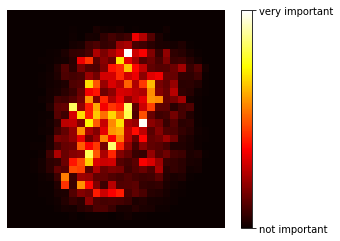

In [27]:
import matplotlib

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
              interpolation='nearest')
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), 
                          rnd_clf.feature_importances_.max()])

cbar.ax.set_yticklabels(['not important', 'very important'])

plt.show()

___
## 7.5 Boosting

**Boosting**은 weak learner들을 여러 개 합하여 strong learner로 만들어 주는 Ensemble method 이다.

대부분의 boosting methods의 일반적인 아이디어는 predictor들을 순차적으로 교육하는 것이며, 각각은 그 이전 방법을 수정하기 위해 노력한다.

> 즉, boosting methods의 아이디어는 앞에서 학습된 모델을 보완해나가면서 더나은 모델로 학습시키는 것.

< **참고** >

![img_4](./imgs/7-5-2.png)

Boosting 도 Bagging과 동일하게 random sampling을 하지만 weight를 부여한다는 차이점이 있다.

Bagging이 parallel로 training되지만, Boosting은 sequential하게 training시킨다.

Boosting은 training이 끝날때 마다 가중치가 재분배 된다.

mis-classified 에 대해 높은 weight를 부여하고, well-classified에 대해 낮은 weight를 주기 때문에 mis-classified 샘플에 대해 더욱 집중 할 수 있다.

Boosting 기법의 경우, 정확도가 높게 나타납니다. 하지만, 그만큼 Outlier에 취약하기도 합니다.


**부스팅 방법에는 여러 종류가 있는데, 그 중 가장 유명하고 인기 있는 모델은 **
1. 아다부스트(AdaBoost, Adaptive Boosting)와 
2. 그래디언트 부스팅(Gradient Boosting) 두 가지가 있다.



___
### 7.5.1 Adaboost

**AdaBoost**는 underfitted(과소적합)됐던 이전의 training instance들에 가중치를 더 주어 새로 train 되는 predictor model이 학습하기 어려운 데이터에 더 잘 fit 시키도록 하는 technique.

< **Adaboot 원리** >
1. 먼저 첫번째 base classifier가 training set에 대해 train하여, predictions(model)을 만든다.
2. 이후 잘못 classified 된 training instance들의 가중치를 상대적으로 높여준다.
3. 그다음 두번째 classifier가 앞서 업데이트된 가중치를 반영하여 predictions(model)을 training 시킨다.
4. 이와 같은 과정을 반복한다. 

![img_5](./imgs/7-5-1.png)

Scikit-Learn에는 AdaBoost를 사용할 수 있도록 AdaBoostClassifier를 제공한다.

___
### example : apply AdaBoost to moons dataset

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

___
### example-1 : Five continuous decision boundaries of predictor.

: 각 predictor는 ***RBF kernel*을 가진 고도로 정규화된 *SVM classifier*이다.**


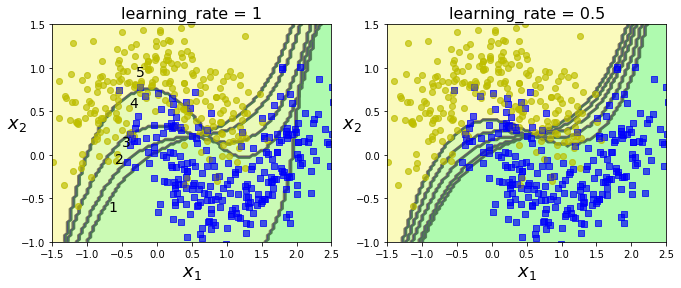

In [34]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)        
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma='auto', random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.show()

moons dataset에 훈련시킨 5개의 연속된 predictor의 decision boundary 입니다.

첫 번째 classifier가 많은 샘플을 잘못 분류해서 이 샘플들의 weight가 높아졌습니다.

두 번째 classifier는 더 정확히 예측하게 됩니다.

오른쪽 그래프는 '**learning rate**'을 반으로 낮춘 predictor 입니다.

Gradient descent 와 AdaBoost는 Sequential learning 기술이라는 점에서 비슷한 면을 보인다.

하지만,Gradient descent은 cost function을 최소화 하기 위해 한 predictor의 parameter을 조정해간다.

Adaboost는 점차 더 좋아지기 위해 Ensemble에 predictor을 추가합니다.

___
### ***WARNING***

> Sequential learning의 하나의 중요한 단점이 있는데 </br>
> 이는 Parallelized 하지 못한다는 것이다. </br>
> 이전의 predictor가 train되고 evaluate 된 후에나 다음 predictor를 train 할 수 있기 때문에,</br>
> 결과적으로 Bagging 과 Pasting 보다는 scale이 작다.

___

### 7.5.1-1 AdaBoost Algorithm

AdaBoost의 논문인 '**A Short Introduction to Boosting**'에서 AdaBoost 알고리즘은 다음과 같다.

![img_7](./imgs/7-5-3.png)


위의 algorithm을 단계별로 보았을때,

![img_8](./imgs/7-5-4.png)

#### **Scikit-Learn에서의 AdaBoost algorithm**

Scikit-Learn 에서는 '**AdaBoostClassifier**'의 multi-class AdaBoost버전인 "***SAMME (Stagewise Additive Modeling using a Multi-class Exponential loss function)***" 와 "***SAMME.R (SAMME. Real)***"을 사용한다. </br> 
(default = '**SAMME.R**')

더욱이 예측 변수가 class probabilities을 추정할 수 있는 경우, Scikit-Learn은 SAMME.R은 예측보다는 class probability을 의존하고 일반적으로 더 잘 수행하는 SAMME의 변형을 사용할 수 있다.




___
### example -2 : apply AdaBoost to moons dataset

> Decision stump (한 개의 decision node와 두 개의 잎 노드로 구성된 나무) == Decision Tree with **max_depth = 1**

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

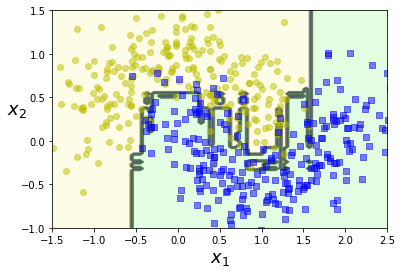

In [30]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), # Decision tree with (max_depth = 1) == Decision Stump
                            n_estimators=200,
                            algorithm='SAMME.R',
                            learning_rate=1,
                            random_state=42)

ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)

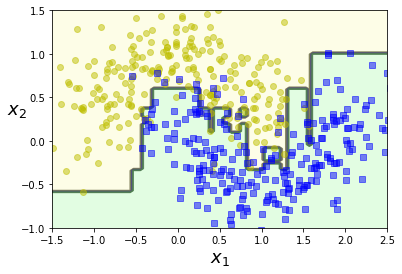

In [31]:
ada_clf_lr = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                            n_estimators=200,
                            algorithm='SAMME.R',
                            learning_rate=0.5,
                            random_state=42)

ada_clf_lr.fit(X_train, y_train)
plot_decision_boundary(ada_clf_lr, X, y)

### < ***TIP*** >

> 만약 AdaBoost ensemble 이 training set에 대해 overfitting 하다면, </br>
> estimator 의 수를 줄이거나 base estimator를 더 강력하게 regularizing 해야한다
___